# Drive Mounting
Appropriate permissions have to given for google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing of necessary libraries

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

--2023-02-12 14:26:44--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2820 (2.8K) [text/plain]
Saving to: ‘icevision_install.sh.1’

icevision_install.s 100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-02-12 14:26:44 (47.2 MB/s) - ‘icevision_install.sh.1’ saved [2820/2820]



In [ ]:
!bash icevision_install.sh cuda11 master

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
- Installing mmcv
- Installing mmdet
- Installing mmseg
- Installing icevision from master
  Preparing metadata (setup.py) ... done
- Installing icedata from master
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
icevision installation finished!


In [15]:
import zipfile
import os
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from icevision.all import *
from pathlib import Path

# Extraction of ZIP

In [2]:
# specify the location of the zip file
zip_file = "/content/drive/MyDrive/Vehicle_Dataset_Modified.zip"

# extract the contents of the zip file to the current working directory
with zipfile.ZipFile(zip_file, 'r') as z:
    z.extractall()

# Data Visualization

A function that reads the xml file and creates a dataframe having necessary values. 

In [1]:
def get_unique_values(xml_path):
    # parse the xml file
    root = ET.parse(xml_path).getroot()

    # extract the values of the <name> and <bndbox> tags within the <object> tag
    objects = []
    for obj in root.iter('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        objects.append([name, xmin, ymin, xmax, ymax])

    # store the unique values of the <name> tag in a pandas dataframe
    df = pd.DataFrame(objects, columns=['Name', 'xmin', 'ymin', 'xmax', 'ymax'])

    # add the image ID column
    image_id = os.path.splitext(os.path.basename(xml_path))[0] + '.jpg'
    df.insert(0, 'image_id', image_id)

    # add the width and height columns
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    df.insert(1, 'width', width)
    df.insert(2, 'height', height)

    return df

Note: 
- Make sure to rename the 'Vehicle Dataset' folder to 'Vehicle_Dataset', else it is going to cause issues while using the function. 

In [2]:
# Testing of function
df = get_unique_values('/content/Vehicle_Dataset/train/annotations/Pias (253).xml')
df

,image_id,width,height,Name,xmin,ymin,xmax,ymax
0,Pias (253).jpg,854,480,bus,601,160,836,411
1,Pias (253).jpg,854,480,car,439,258,612,379
2,Pias (253).jpg,854,480,car,1,271,526,480
3,Pias (253).jpg,854,480,car,59,228,152,274
4,Pias (253).jpg,854,480,car,358,248,509,293
5,Pias (253).jpg,854,480,car,332,243,404,275
6,Pias (253).jpg,854,480,three wheelers (CNG),541,244,603,261
7,Pias (253).jpg,854,480,three wheelers (CNG),154,227,337,275
8,Pias (253).jpg,854,480,minivan,449,232,556,255
9,Pias (253).jpg,854,480,three wheelers (CNG),1,221,66,275


In [3]:
# path of the directory containing the XML files
path = '/content/Vehicle_Dataset/train/annotations/'

# list of XML files in the directory
xml_files = [f for f in os.listdir(path) if f.endswith('.xml')]
xml_files_df = pd.DataFrame({"filename": xml_files})
xml_files_df['path'] = xml_files_df['filename'].apply(lambda x: os.path.join(path, x))
xml_files_df

,filename,path
0,Numan_(62).xml,/content/Vehicle_Dataset/train/annotations/Num...
1,Navid_702.xml,/content/Vehicle_Dataset/train/annotations/Nav...
2,Numan_(313).xml,/content/Vehicle_Dataset/train/annotations/Num...
3,Navid_762.xml,/content/Vehicle_Dataset/train/annotations/Nav...
4,Dipto_577.xml,/content/Vehicle_Dataset/train/annotations/Dip...
...,...,...
2998,Navid_117.xml,/content/Vehicle_Dataset/train/annotations/Nav...
2999,Numan_(87).xml,/content/Vehicle_Dataset/train/annotations/Num...
3000,Pias (449).xml,/content/Vehicle_Dataset/train/annotations/Pia...
3001,Pias (498).xml,/content/Vehicle_Dataset/train/annotations/Pia...


I faced some issues when I was trying to create a dataframe containing all the classes in all the xml files. This was done to understand the data. Hence, the following code block has been executed to find out the faulty xml file.

In [4]:
path_list = xml_files_df['path'].tolist()
for row in path_list:
  try:
    values = get_unique_values(row)
  except Exception as e:
    print("Skipping file with error:", row)
    continue

Skipping file with error: /content/Vehicle_Dataset/train/annotations/231.xml


The faulty xml file is then removed from the dataframe.

In [5]:
xml_files_df = xml_files_df[xml_files_df['filename'] != '231.xml']

The following code block reads all the xml files, creating a dataframes of the classes present in xml files using the 'get_unique_values' function. Those dataframes are then concatenated vertically.

In [6]:
unique_classes = pd.concat([get_unique_values(x) for x in xml_files_df['path']], axis=0)

In [7]:
unique_classes.reset_index(drop=True)

,image_id,width,height,Name,xmin,ymin,xmax,ymax
0,Numan_(62).jpg,1920,1080,three wheelers (CNG),308,568,559,810
1,Numan_(62).jpg,1920,1080,three wheelers (CNG),633,570,773,719
2,Numan_(62).jpg,1920,1080,three wheelers (CNG),784,563,893,695
3,Numan_(62).jpg,1920,1080,rickshaw,891,521,1142,734
4,Numan_(62).jpg,1920,1080,rickshaw,1272,508,1398,668
...,...,...,...,...,...,...,...,...
24363,Numan_(450).jpg,1080,1920,car,225,762,430,877
24364,Numan_(450).jpg,1080,1920,car,559,772,668,848
24365,Numan_(450).jpg,1080,1920,bicycle,838,756,890,898
24366,Numan_(450).jpg,1080,1920,motorbike,767,765,798,827


Some images in the 'train' folder had differnt format. The corresponding image_id's have been replaced.

In [8]:
# Define the replacements
replacements = {'06.jpg': '06.jpeg', '65.jpg': '65.jpeg'}
# Replace the values in the 'image_id' column using the 'replace' method
unique_classes['image_id'] = unique_classes['image_id'].replace(replacements)

# Define the replacements
replacements1 = {'Pias (359).jpg': 'Pias (359).PNG', 'Pias (360).jpg': 'Pias (360).PNG'}
# Replace the values in the 'image_id' column using the 'replace' method
unique_classes['image_id'] = unique_classes['image_id'].replace(replacements1)


# Create a list of image ids that need to be replaced
to_replace = [f"{i}.jpg" for i in range(193, 206)]
# Create a list of new image ids
replace_with = [f"{i}.png" for i in range(193, 206)]
# Replace the image ids in the 'image_id' column
unique_classes['image_id'] = unique_classes['image_id'].replace(to_replace, replace_with)

To plot a bar chart, we need the class to be unique and the class count. Hence, a separate dataframe is created having just the columns 'Name' and 'Count'

In [9]:
classes = unique_classes['Name']

In [10]:
classes = pd.DataFrame(classes)
classes.reset_index(drop=True)

,Name
0,three wheelers (CNG)
1,three wheelers (CNG)
2,three wheelers (CNG)
3,rickshaw
4,rickshaw
...,...
24363,car
24364,car
24365,bicycle
24366,motorbike


In [11]:
# count the number of times each unique name appears
classes['count'] = classes.groupby(['Name'])['Name'].transform('count')

# drop the duplicates
classes = classes.drop_duplicates(subset='Name', keep='first')
classes.reset_index(drop=True)

,Name,count
0,three wheelers (CNG),2990
1,rickshaw,3549
2,bus,3340
3,car,5476
4,bicycle,459
5,motorbike,2284
6,van,756
7,truck,1492
8,pickup,1225
9,minivan,935


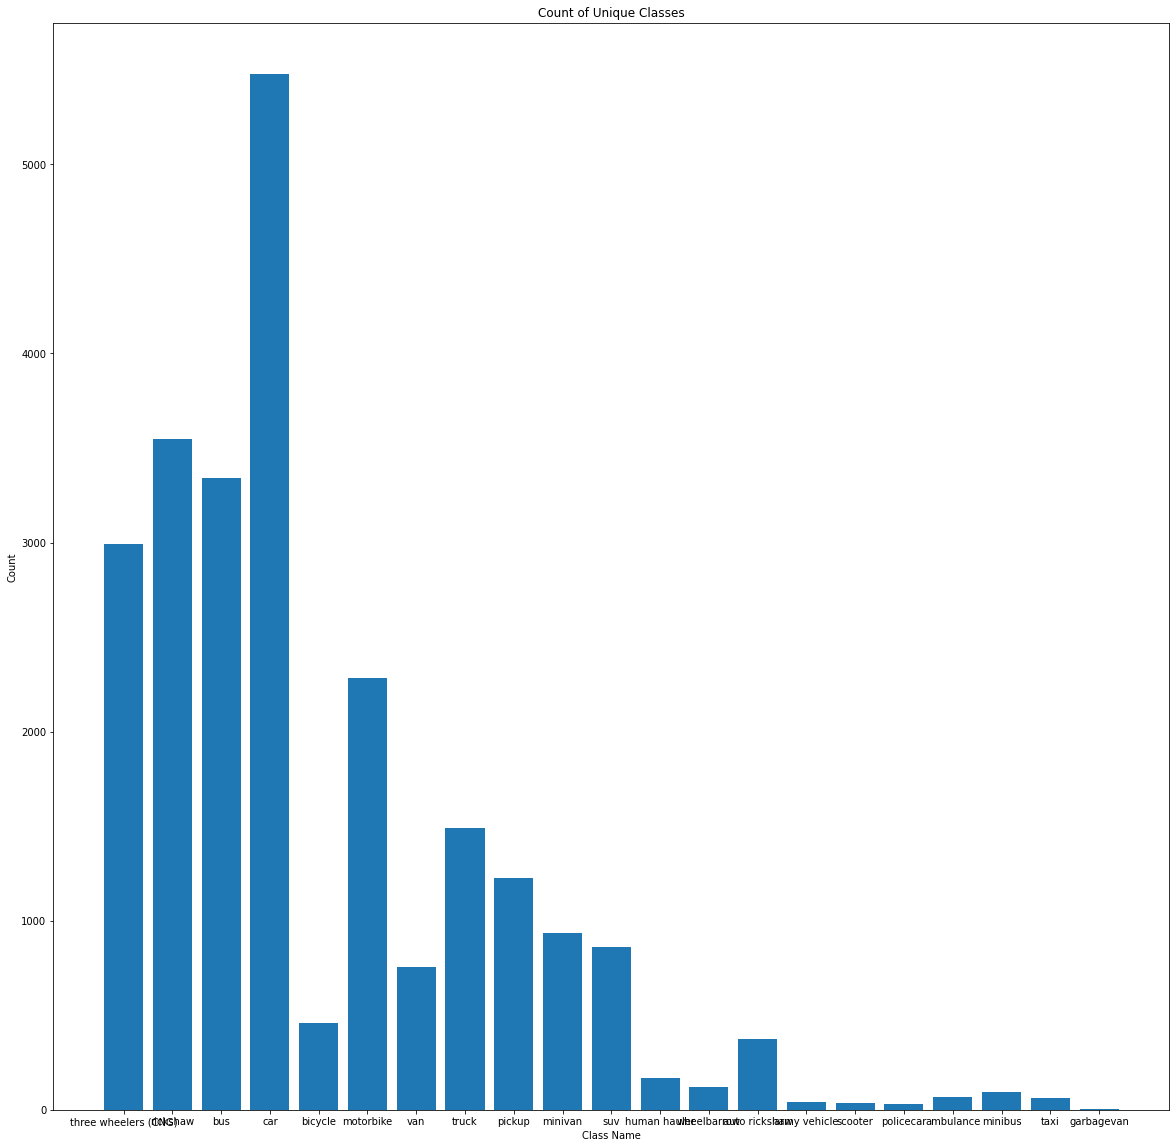

In [12]:
# Create a bar chart with the x values as 'name' and y values as 'count'
fig = plt.figure(figsize=(20,20))
plt.bar(classes['Name'], classes['count'])

# Add labels to the x and y axes
plt.xlabel('Class Name')
plt.ylabel('Count')

# Add a title to the chart
plt.title('Count of Unique Classes')

# Display the chart
plt.show()

As you can see, the classes are skewed. The mAP value would be very low when we are trying to predict all the classes. For the model to perform better, either more data on under-represented classes has to be collected or the loss function can be tuned. Focusing on those classes which are occuring frequently could also increase the mAP value drastically. 

# Creating Custom Parser

**Setting Images and Annotations directories**

In [16]:
data_dir = Path('/content/Vehicle_Dataset/train')

images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [13]:
class_list = classes['Name'].tolist()
class_list

['three wheelers (CNG)',
 'rickshaw',
 'bus',
 'car',
 'bicycle',
 'motorbike',
 'van',
 'truck',
 'pickup',
 'minivan',
 'suv',
 'human hauler',
 'wheelbarrow',
 'auto rickshaw',
 'army vehicle',
 'scooter',
 'policecar',
 'ambulance',
 'minibus',
 'taxi',
 'garbagevan']

**Defining class_map**

In [17]:
class_map = ClassMap(['van',
 'bus',
 'truck',
 'army vehicle',
 'three wheelers (CNG)',
 'rickshaw',
 'human hauler',
 'suv',
 'car',
 'bicycle',
 'motorbike',
 'pickup',
 'ambulance',
 'auto rickshaw',
 'wheelbarrow',
 'minivan',
 'taxi',
 'garbagevan',
 'minibus',
 'scooter',
 'policecar'])

**Creating parser template** 

In [18]:
template_record = ObjectDetectionRecord()
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_img_size(<ImgSize>)
        record.set_filepath(<Union[str, Path]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)
        record.detection.add_bboxes(<Sequence[BBox]>)


> https://airctic.com/0.12.0/custom_parser/

**Creating parser**

In [20]:
class VehicleParser(Parser):
    def __init__(self, template_record, data_dir): # data_dir tells the path of images
        super().__init__(template_record=template_record)

        self.data_dir = data_dir # data_dir tells the path of images
        self.df = unique_classes # tells the data format of the annotations
        self.class_map = ClassMap(list(self.df['Name'].unique())) # column name corresponding to classes

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.image_id # column name corresponding to filenames 

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.image_id) # complete image path
            record.set_img_size(ImgSize(width=o.width, height=o.height)) # width, height column names
            record.detection.set_class_map(self.class_map) # class_map

        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)]) # point column names
        record.detection.add_labels([o.Name]) # class column names 

In [21]:
parser = VehicleParser(template_record, data_dir)

The following files had issues with bounding box values. Xmin/Ymin value was greater than Xmax/Ymax, which should not be the case. Hence, they have been removed to avoid discrepancies.

In [2]:
os.remove("/content/Vehicle_Dataset/train/images/Pias (359).PNG")
os.remove("/content/Vehicle_Dataset/train/images/Pias (360).PNG")

# Data Preparation

In [22]:
train_records, valid_records = parser.parse()

  0%|          | 0/24368 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/3002 [00:00<?, ?it/s]

WARNING  - (record_id: Navid_635.jpg) - 🚫 Record could not be autofixed and will be removed because: File '/content/Vehicle_Dataset/train/images/Navid_635.jpg' does not exist | icevision.core.record:autofix_records:100
WARNING  - (record_id: 88.jpg) - 🚫 Record could not be autofixed and will be removed because: File '/content/Vehicle_Dataset/train/images/88.jpg' does not exist | icevision.core.record:autofix_records:100
WARNING  - (record_id: Navid_590.jpg) - 🚫 Record could not be autofixed and will be removed because: File '/content/Vehicle_Dataset/train/images/Navid_590.jpg' does not exist | icevision.core.record:autofix_records:100
WARNING  - (record_id: Navid_646.jpg) - 🚫 Record could not be autofixed and will be removed because: File '/content/Vehicle_Dataset/train/images/Navid_646.jpg' does not exist | icevision.core.record:autofix_records:100
WARNING  - (record_id: Navid_598.jpg) - 🚫 Record could not be autofixed and will be removed because: File '/content/Vehicle_Dataset/train/

# Datasets
**Transforms**

In [23]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

**Training and Validation** 

In [24]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

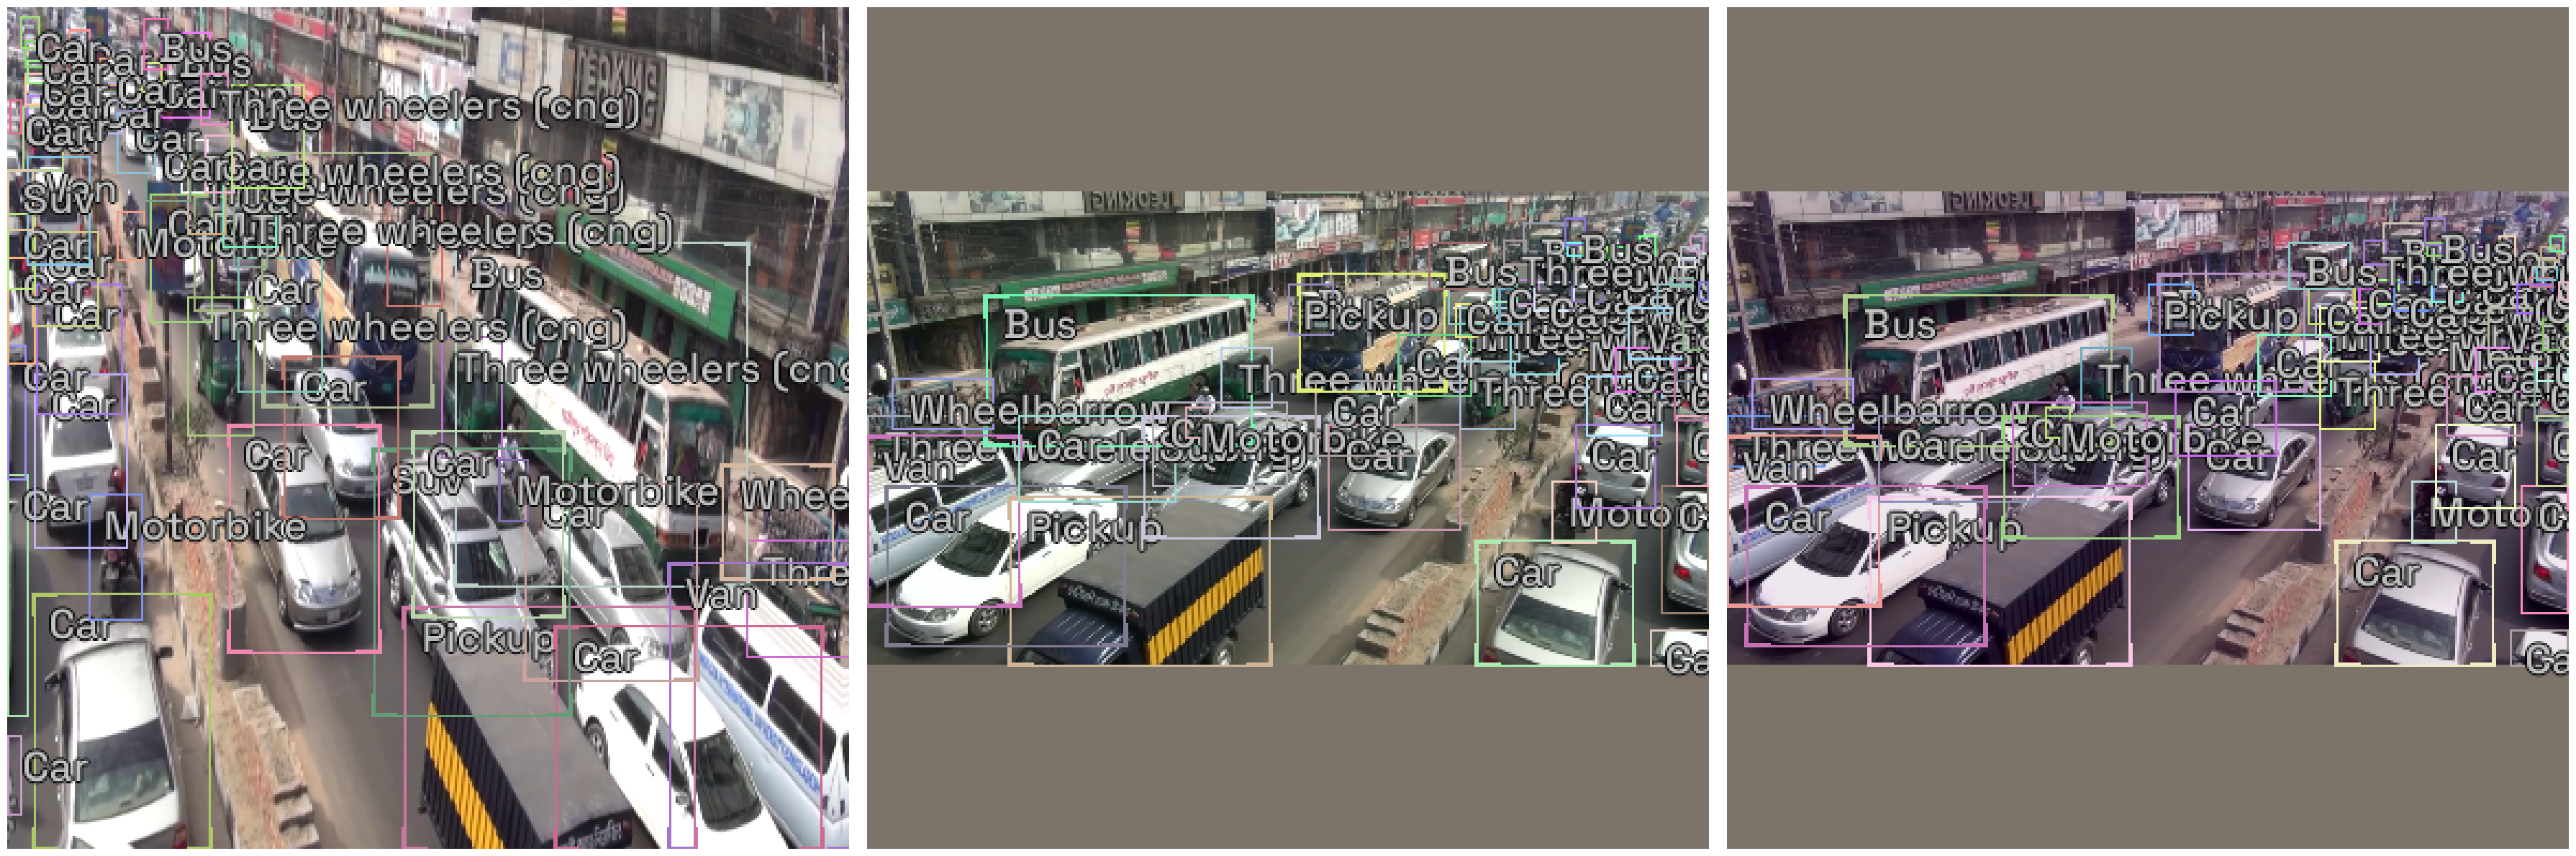

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

# Models

In [ ]:
selection = 3

extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

In [27]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

In [28]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Fastai Learner**

In [29]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [30]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

Run the following two code blocks when you get an error with images. Reload the notebook without fail and do not delete the runtime instead.

In [ ]:
pip install pytesseract

In [32]:
!pip3 install --upgrade Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
icevision 0.12.0 requires pillow<9,>8.0.0, but you have pillow 9.4.0 which is incompatible.


# Fastai Training
**Learning Rate Finder**

data: {'image': array([[[218, 218, 218],
        [132, 132, 132],
        [153, 153, 153],
        ...,
        [248, 248, 222],
        [243, 242, 222],
        [238, 236, 221]],

       [[156, 156, 156],
        [ 27,  27,  27],
        [ 15,  15,  15],
        ...,
        [253, 253, 227],
        [248, 247, 226],
        [242, 240, 225]],

       [[174, 174, 174],
        [ 22,  22,  22],
        [  4,   4,   4],
        ...,
        [255, 255, 228],
        [251, 250, 229],
        [245, 244, 226]],

       ...,

       [[187, 181, 169],
        [ 64,  58,  46],
        [ 60,  54,  40],
        ...,
        [133, 130, 113],
        [140, 137, 122],
        [202, 200, 188]],

       [[167, 160, 150],
        [ 63,  56,  46],
        [ 61,  55,  43],
        ...,
        [139, 136, 119],
        [140, 136, 124],
        [196, 194, 182]],

       [[233, 226, 218],
        [158, 151, 143],
        [156, 149, 139],
        ...,
        [189, 186, 169],
        [184, 180, 168],
        

SuggestedLRs(valley=0.0010000000474974513)

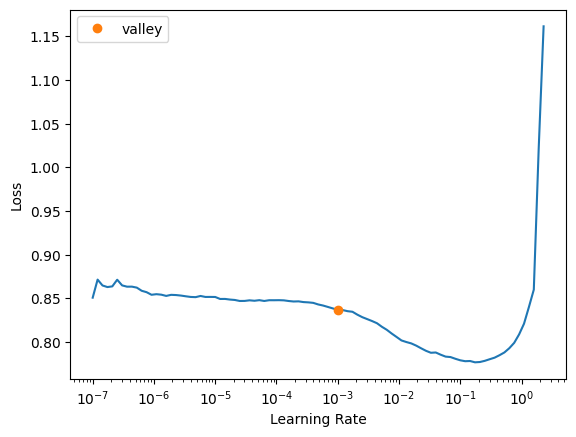

In [31]:
learn.lr_find()

1.   https://github.com/albumentations-team/albumentations/issues/459
2.   https://github.com/albumentations-team/albumentations/issues/353

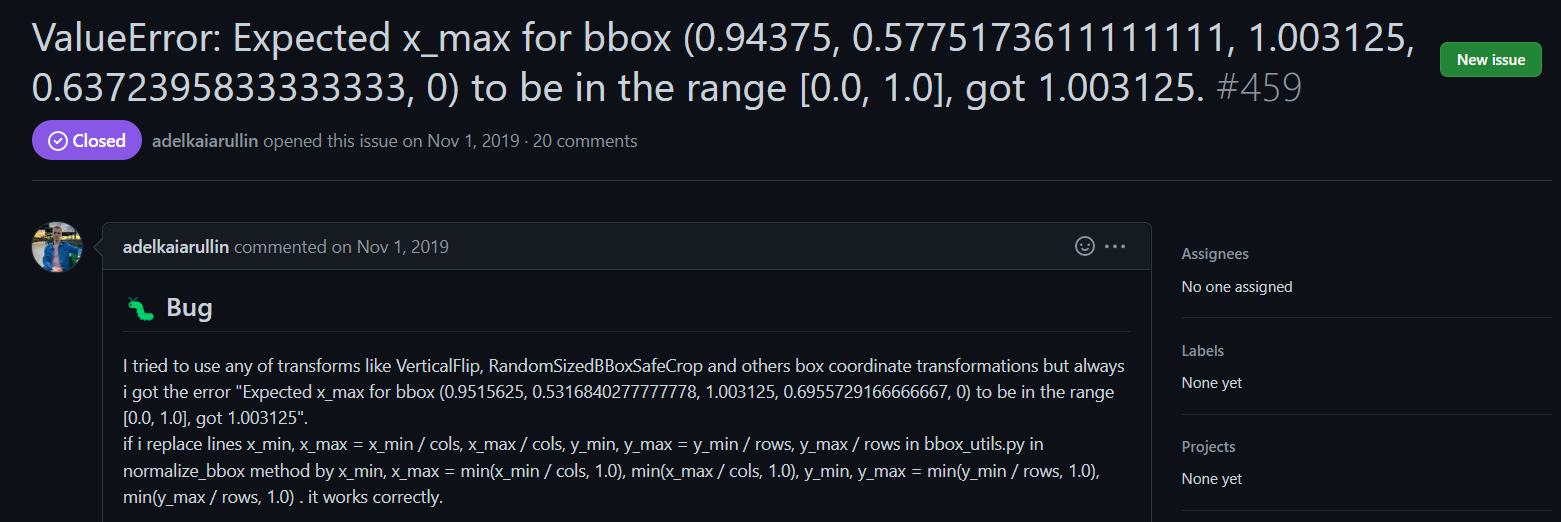

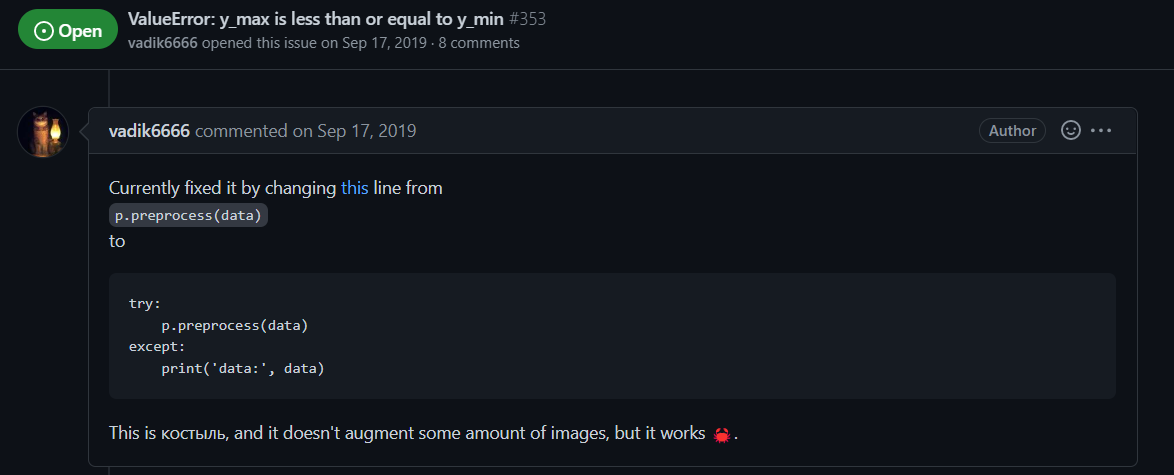

**Fine Tuning**

In [32]:
learn.fine_tune(20, 1e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.571741,0.511498,0.017723,03:13


data: {'image': array([[[230, 230, 228],
        [225, 225, 223],
        [236, 236, 234],
        ...,
        [231, 231, 231],
        [230, 230, 230],
        [230, 230, 230]],

       [[213, 213, 211],
        [167, 167, 165],
        [164, 164, 162],
        ...,
        [141, 141, 141],
        [146, 146, 146],
        [146, 146, 146]],

       [[166, 166, 164],
        [ 72,  72,  70],
        [ 55,  55,  53],
        ...,
        [ 19,  19,  19],
        [ 16,  16,  16],
        [ 16,  16,  16]],

       ...,

       [[212, 201, 179],
        [139, 127, 105],
        [138, 126, 102],
        ...,
        [ 99,  92,  76],
        [ 90,  83,  67],
        [ 90,  83,  67]],

       [[209, 198, 176],
        [136, 124, 102],
        [136, 124, 100],
        ...,
        [ 95,  88,  72],
        [ 92,  85,  69],
        [ 92,  85,  69]],

       [[209, 198, 176],
        [136, 124, 102],
        [136, 124, 100],
        ...,
        [ 94,  87,  71],
        [ 92,  85,  69],
        

/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,COCOMetric,time
0,0.481711,0.440614,0.036244,03:15
1,0.451958,0.412100,0.045892,03:13
2,0.419600,0.392980,0.057641,03:13
3,0.411709,0.376274,0.067918,03:09
4,0.402476,0.364856,0.075077,03:09
5,0.389446,0.358139,0.075752,03:10
6,0.383363,0.353351,0.085600,03:11
7,0.378005,0.342140,0.089434,03:10
8,0.361506,0.337438,0.094435,03:08
9,0.357922,0.335953,0.098169,03:09


data: {'image': array([[[230, 230, 228],
        [225, 225, 223],
        [236, 236, 234],
        ...,
        [231, 231, 231],
        [230, 230, 230],
        [230, 230, 230]],

       [[213, 213, 211],
        [167, 167, 165],
        [164, 164, 162],
        ...,
        [141, 141, 141],
        [146, 146, 146],
        [146, 146, 146]],

       [[166, 166, 164],
        [ 72,  72,  70],
        [ 55,  55,  53],
        ...,
        [ 19,  19,  19],
        [ 16,  16,  16],
        [ 16,  16,  16]],

       ...,

       [[212, 201, 179],
        [139, 127, 105],
        [138, 126, 102],
        ...,
        [ 99,  92,  76],
        [ 90,  83,  67],
        [ 90,  83,  67]],

       [[209, 198, 176],
        [136, 124, 102],
        [136, 124, 100],
        ...,
        [ 95,  88,  72],
        [ 92,  85,  69],
        [ 92,  85,  69]],

       [[209, 198, 176],
        [136, 124, 102],
        [136, 124, 100],
        ...,
        [ 94,  87,  71],
        [ 92,  85,  69],
        

The mAP for RetinaNet after 20 epochs: 0.114518

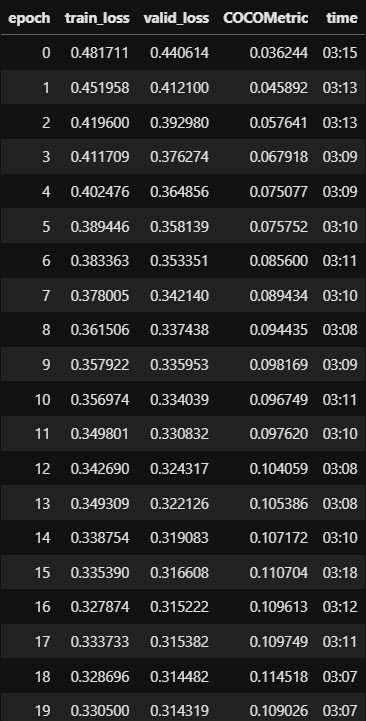

# Show results

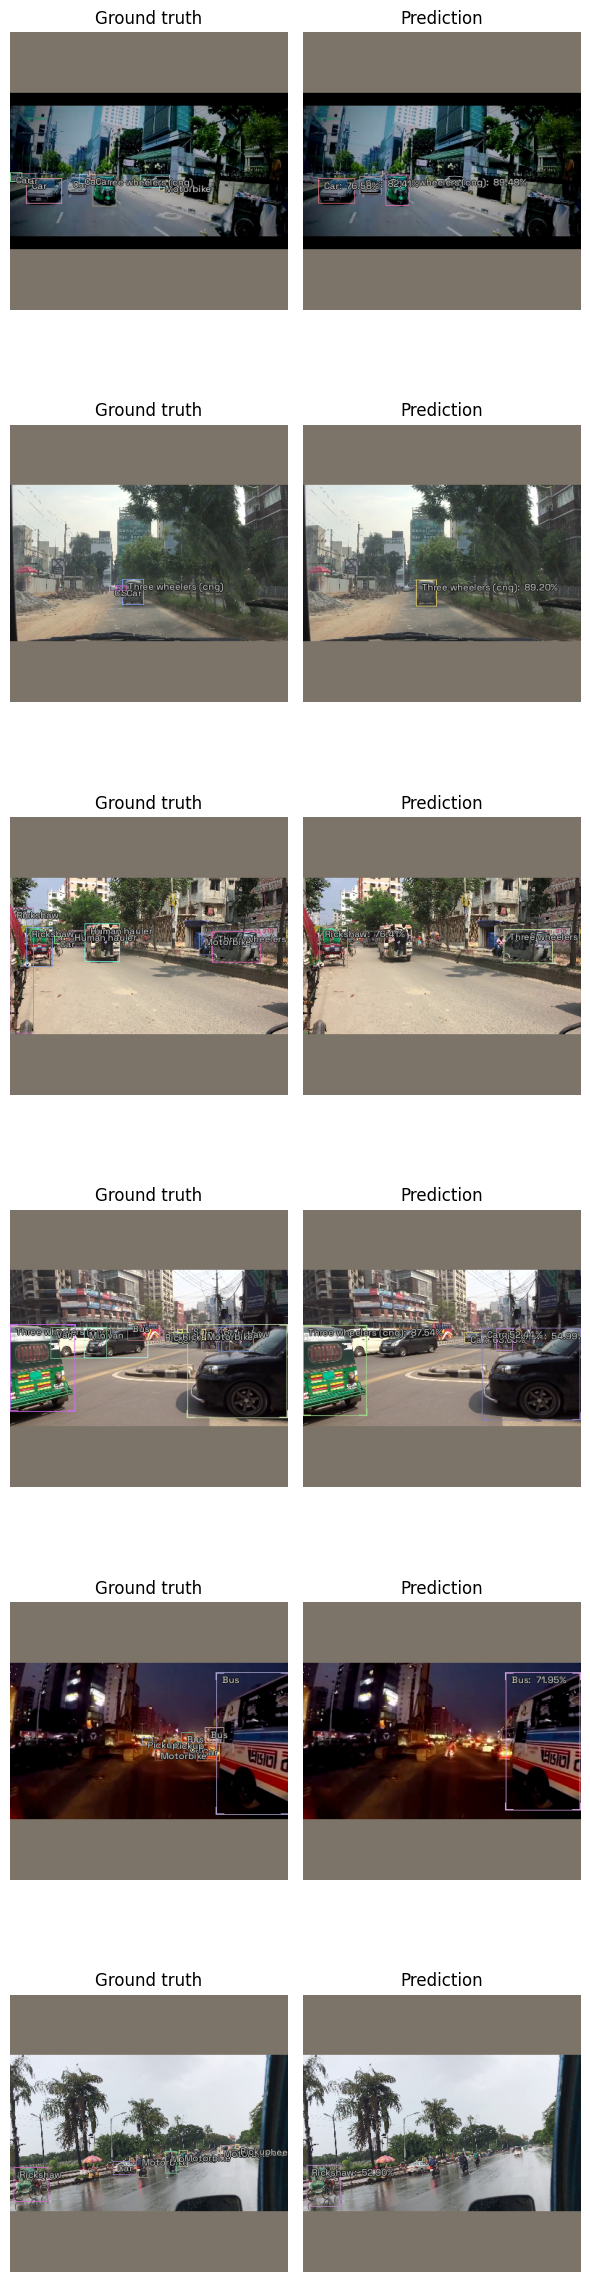

In [33]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

# Predictions

In [34]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/143 [00:00<?, ?it/s]

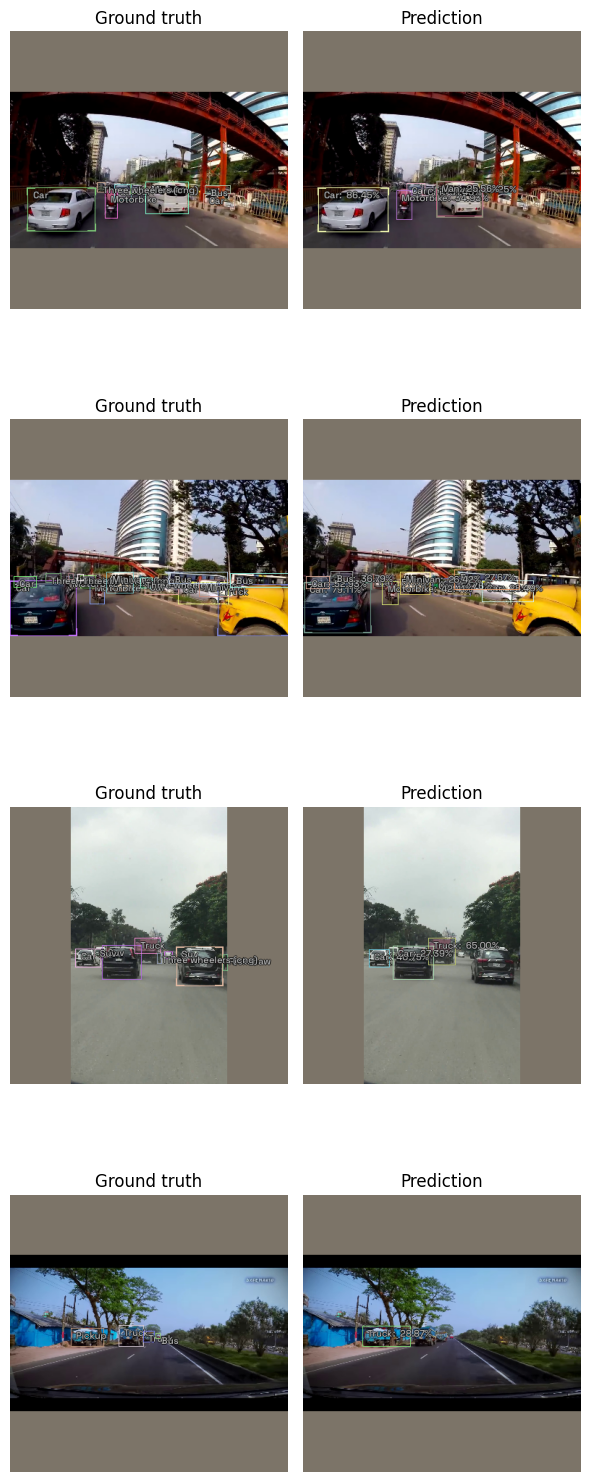

In [35]:
show_preds(preds=preds[:4])